# Pre-Analysis of the audios files

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
from utils.format_helpers import analyze_audio_files, extract_id

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Raw Audio Analysis (Meditation)

In [16]:
directories = ["../data/OBE1","../data/OBE2","../data/Compassion"]
extensions = ["m4a","wav","mp4"]

df = analyze_audio_files(directories, extensions)

df.to_csv("outputs/audio_data.csv", index=False)
df

,File_name,Format,ID,Duration,Duration_timedelta,Duration_sec,Experiment
0,ID 05,.mp4,5,00:10:15,0 days 00:10:15.680000,615.68,OBE1
1,Id 08,.m4a,8,00:04:34,0 days 00:04:34.650000,274.65,OBE1
2,Id 13,.m4a,13,00:07:19,0 days 00:07:19.700000,439.70,OBE1
3,Id 13b,.m4a,13,00:03:21,0 days 00:03:21.600000,201.60,OBE1
4,Id 14,.m4a,14,00:02:52,0 days 00:02:52.970000,172.97,OBE1
...,...,...,...,...,...,...,...
77,S304,.m4a,304,00:07:05,0 days 00:07:05.920000,425.92,Compassion
78,S305con,.m4a,305,00:01:41,0 days 00:01:41.100000,101.10,Compassion
79,S306,.m4a,306,00:08:50,0 days 00:08:50.710000,530.71,Compassion
80,S307,.m4a,307,00:06:15,0 days 00:06:15.700000,375.70,Compassion


In [13]:
# Group by 'Experiment' and sum durations
print(df.groupby('Experiment')['Duration_timedelta'].sum())
print(df['Duration_timedelta'].sum())


Experiment
Compassion   0 days 01:00:53.870000
OBE1         0 days 01:22:57.510000
OBE2         0 days 04:55:58.040000
Name: Duration_timedelta, dtype: timedelta64[ns]
0 days 07:19:49.420000


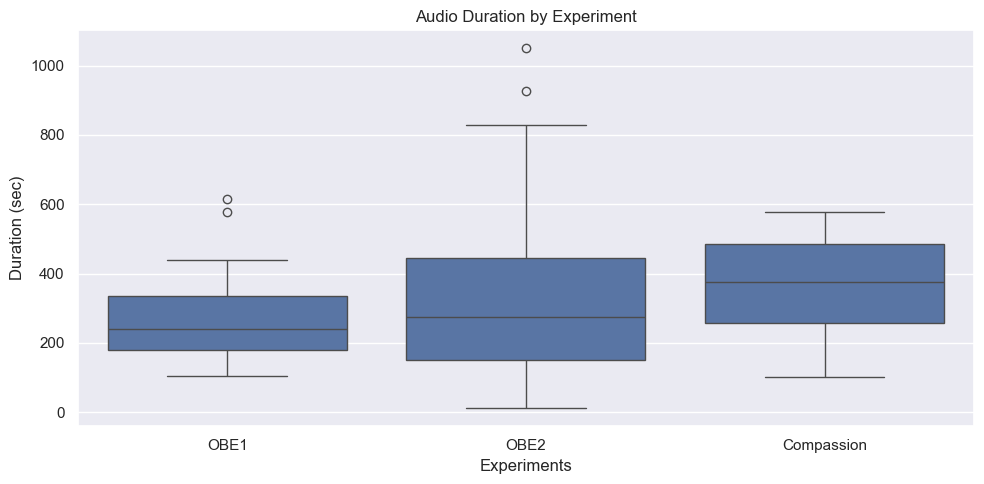

In [3]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Experiment', y='Duration_sec', data=df)

plt.title('Audio Duration by Experiment')
plt.xlabel('Experiments')
plt.ylabel('Duration (sec)')

plt.tight_layout()
plt.show()

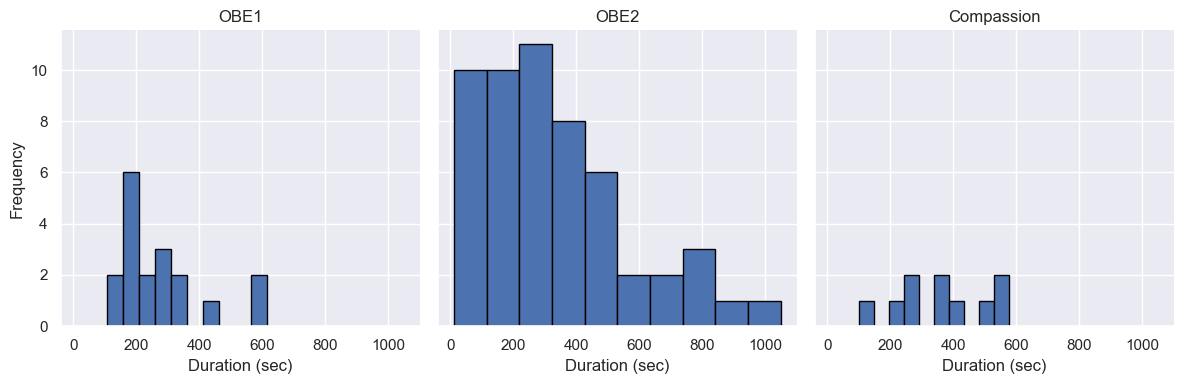

In [4]:
# Create a FacetGrid for separate histograms for each experiment
g = sns.FacetGrid(df, col="Experiment", col_wrap=3, height=4)

g.map(plt.hist, "Duration_sec", bins = 10 ,edgecolor='black') #color='skyblue', bins=10

g.set_titles("{col_name}")
g.set_axis_labels("Duration (sec)", "Frequency")

plt.tight_layout()
plt.show()

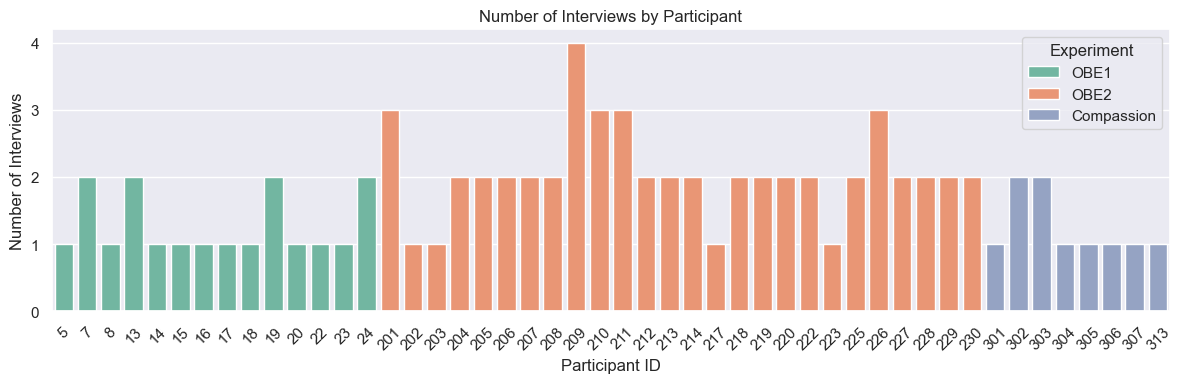

In [5]:
plt.figure(figsize=(12, 4))
sns.countplot(x='ID', hue='Experiment', data=df, palette='Set2')

plt.title('Number of Interviews by Participant')
plt.xlabel('Participant ID')
plt.ylabel('Number of Interviews')
plt.xticks(rotation=45)
plt.legend(title='Experiment')
# Set y-axis to show only integers
plt.yticks(range(0, int(df['ID'].value_counts().max()) + 1))

plt.tight_layout()
#plt.savefig('interviews_by_participant.png', dpi=600)
plt.show()

## Get the order of the conditions for each experiment (Meditation)

Final version, need to be completed & verified manually. 
- Done and actually located at **interviews_corrected** folder.

**C** : Control ; **I** : Intervention ; **1** : Only one interview ; **0** : No interview (eg. Set-up)

In [ ]:
df = pd.read_csv("outputs/audio_data.csv")
# Compassion
conditions_compassion = pd.read_csv("../data/Compassion/Compassion_orders.csv")
conditions_compassion["ID"] = conditions_compassion["Number"].apply(extract_id)
# If the first word is control -> CI, otherwise -> IC
conditions_compassion["Order_Condition"] = conditions_compassion["order"].apply(lambda x: "CI" if x.split()[0] == "control" else "IC")

# OBE2
conditions_obe2 = pd.read_excel("../Data/OBE2/Order_of_conditions.xlsx")
conditions_obe2["ID"] = conditions_obe2["Identification No."].apply(extract_id)
# CM -> CI, otherwise -> IC
conditions_obe2["Order_Condition"] = conditions_obe2["Order"].apply(lambda x: "CI" if x == "CM" else "IC")

# OBE1
conditions_obe1 = pd.read_csv("../Data/OBE1/order_OBE1.csv")
conditions_obe1["ID"] = conditions_obe1["subjID"]
conditions_obe1["Order_Condition"] = conditions_obe1["order"].apply(lambda x: "CI" if x == "CM" else "IC")

# Combine all conditions
conditions = pd.concat([conditions_compassion, conditions_obe2, conditions_obe1], ignore_index=True)
df = pd.merge(df, conditions[["ID","Order_Condition"]], on="ID", how="left")

# Create the 'Condition' column and set initial values to None
df["Condition"] = None
df = df.sort_values(by=['ID', 'File_name'])

def assign_condition(row):
    # Get rows for the same ID in any experiment
    id_group = df[df['ID'] == row['ID']]
    
    # If there is only one file for this ID, set Condition to "1"
    if len(id_group) == 1:
        return "1"
    
    # Assign 'Condition' based on alphabetical order in 'OBE2' and 'OBE1'
    if row['Experiment'] in ['OBE1', 'OBE2']  and len(id_group) == 2:
        if row.name == id_group.index[0]:
            return row['Order_Condition'][0]
        elif row.name == id_group.index[1]:
            return row['Order_Condition'][1]
    
    # For other cases, leave Condition as None
    return row['Condition']

# Apply the function to assign conditions
df['Condition'] = df.apply(assign_condition, axis=1)

# Select specific columns and save the final structured data
df = df[["Experiment", "File_name", "ID", "Duration", "Order_Condition", "Condition"]]

df.to_csv("outputs/structured_data.csv", index=False)
df

,Experiment,File_name,ID,Duration,Order_Condition,Condition
0,OBE1,ID 05,5,00:10:15,IC,1
15,OBE1,Id 7a,7,00:09:38,IC,I
16,OBE1,Id 7b,7,00:04:01,IC,C
1,OBE1,Id 08,8,00:04:34,CI,1
2,OBE1,Id 13,13,00:07:19,IC,I
...,...,...,...,...,...,...
77,Compassion,S304,304,00:07:05,CI,1
78,Compassion,S305con,305,00:01:41,CI,1
79,Compassion,S306,306,00:08:50,IC,1
80,Compassion,S307,307,00:06:15,CI,1


## Raw Audio Analysis (Grief)

In [ ]:
directories = ["../data/Grief/eng","../data/Grief/fr"]
extensions = ["m4a","wav","mp4"]

df = analyze_audio_files(directories, extensions)

df.to_csv("outputs/GRIEF_audio_data.csv", index=False)
df

,File_name,Format,ID,Duration,Duration_timedelta,Duration_sec,Experiment
0,ADE_pilot_003_interview_04.10.24_part1,.wav,3,00:47:37,0 days 00:47:37.600000,2857.60,eng
1,ADE_pilot_003_interview_04.10.24_part2,.wav,3,00:21:00,0 days 00:21:00.380000,1260.38,eng
2,ADE_pilot_004_interview_15.10.24_part1,.wav,4,00:47:36,0 days 00:47:36.160000,2856.16,eng
3,ADE_pilot_004_interview_15.10.24_part2,.wav,4,00:12:27,0 days 00:12:27.260000,747.26,eng
4,ADE_pilot_005_interview_part1,.wav,5,00:47:35,0 days 00:47:35.680000,2855.68,eng
5,ADE_pilot_005_interview_part2,.wav,5,00:01:25,0 days 00:01:25.340000,85.34,eng
6,ADE_pilot_006_interview_30.10.24_part1,.wav,6,00:47:36,0 days 00:47:36.160000,2856.16,eng
7,ADE_pilot_006_interview_30.10.24_part2,.wav,6,00:12:07,0 days 00:12:07.580000,727.58,eng
8,ADE_pilot_007_interview_part1,.wav,7,00:47:36,0 days 00:47:36.640000,2856.64,eng
9,ADE_pilot_007_interview_part2,.wav,7,00:07:07,0 days 00:07:07.100000,427.10,eng


In [ ]:
# Group by 'Experiment' and sum durations
print(df.groupby('Experiment')['Duration_timedelta'].sum())
print(df['Duration_timedelta'].sum())


Experiment
eng   0 days 08:45:59.040000
fr    0 days 02:31:20.340000
Name: Duration_timedelta, dtype: timedelta64[ns]
0 days 11:17:19.380000
